## Introduction

In this project, we'll focus on modeling a borrower's credit risk. We'll be working with financial lending data from [Lending Club](https://www.lendingclub.com/). Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return.

Each borrower fills out a comprehensive application, providing their past financial history, the reason for the loan, and more. Lending Club evaluates each borrower's credit score using past historical data and assign an interest rate to the borrower. The interest rate is the percent in addition to the requested loan amount the borrower has to pay back. More info about the interest rate that Lending Club assigns is available [here](https://www.lendingclub.com/public/borrower-rates-and-fees.action). Lending Club also tries to verify each piece of information the borrower provides but it can't always verify all of the information (usually for regulation reasons).

A higher interest rate means that the borrower is riskier and more unlikely to pay back the loan while a lower interest rate means that the borrower has a good credit history is more likely to pay back the loan. The interest rates range from 5.32% all the way to 30.99% and each borrower is given a grade according to the interest rate they were assigned. If the borrower accepts the interest rate, then the loan is listed on the Lending Club marketplace.

Investors are primarily interested in receiving a return on their investments. Approved loans are listed on the Lending Club website, where qualified investors can browse recently approved loans, the borrower's credit score, the purpose for the loan, and other information from the application. Once they're ready to back a loan, they select the amount of money they want to fund. Once a loan's requested amount is fully funded, the borrower receives the money they requested minus the origination fee that Lending Club charges.

The borrower then makes monthly payments back to Lending Club either over 36 months or over 60 months. Lending Club redistributes these payments to the investors. This means that investors don't have to wait until the full amount is paid off before they see a return in money. If a loan is fully paid off on time, the investors make a return which corresponds to the interest rate the borrower had to pay in addition to the requested amount. Many loans aren't completely paid off on time, however, and some borrowers default on the loan.

Most investors use a portfolio strategy to invest small amounts in many loans, with healthy mixes of low, medium, and interest loans. In this project, we'll focus on the mindset of a conservative investor who only wants to invest in the loans that have a good chance of being paid off on time. To do that, we'll need to first understand the features in the dataset and then experiment with building machine learning models that reliably predict if a loan will be paid off or not.

## Description of data and problem statement

Lending Club releases data for all of the approved and declined loan applications periodically [on their website](https://www.lendingclub.com/info/download-data.action). 

There is also a [data dictionary](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit), which contains information on the different column names. The LoanStats sheet describes the approved loans datasets and the RejectStats describes the rejected loans datasets. Since rejected applications don't appear on the Lending Club marketplace and aren't available for investment, we'll be focusing on data on approved loans only.

The approved loans datasets contain information on current loans, completed loans, and defaulted loans. Let's now define the problem statement for this machine learning project:

**Can we build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not?**

Before we can start doing machine learning, we need to define what features we want to use and which column represents the target column we want to predict.

We'll be analyzing approved loans data from 2007 to 2011, since a good number of the loans have already finished. In the datasets for later years, many of the loans are current and still being paid off.

The sataset was reduced the size to make it easier to work with, by:

- removing the desc column:<br>which contains a long text explanation for each loan
- removing the url column:<br>which contains a link to each loan on Lending Club which can only be accessed with an investor account
- removing all columns containing more than 50% missing values:<br>which allows us to move faster since we can spend less time trying to fill these values

Let's read the data.

## Getting familiar with the data

In [1]:
import pandas as pd
df = pd.read_csv("loans_2007.csv")
loans_2007 = df.copy()
loans_2007.drop_duplicates()
loans_2007.shape

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42538, 52)

We need to select only meaningful columns, in doing so we'll pay attention to any features that:

- leak information from the future (after the loan has already been funded)
- don't affect a borrower's ability to pay back a loan (e.g. a randomly generated ID value by Lending Club)
- formatted poorly and need to be cleaned up
- require more data or a lot of processing to turn into a useful feature
- contain redundant information

Let's look at the fields.

In [2]:
fields_description = pd.read_excel('LCDataDictionary.xlsx')
fields = pd.concat([loans_2007.dtypes,loans_2007.iloc[0]],axis = 1).merge(fields_description,
                                                                 left_index = True,
                                                                 right_on = 'LoanStatNew',
                                                                 how = 'left').set_index('LoanStatNew')
fields.columns = ['type','example','description']
# uncomment below to install tabulate
# import sys
# !{sys.executable} -m pip install tabulate

# uncomment below to print markdown for the table
# from tabulate import tabulate
# print(tabulate(fields, headers=fields.columns, tablefmt="github"))

With the above code, we obtained the following table:

|                            | type    | example         | description                                                                                                                                                                                              |
|----------------------------|---------|-----------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| id                         | object  | 1077501         | A unique LC assigned ID for the loan listing.                                                                                                                                                            |
| member_id                  | float64 | 1296599.0       | A unique LC assigned Id for the borrower member.                                                                                                                                                         |
| loan_amnt                  | float64 | 5000.0          | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.                             |
| funded_amnt                | float64 | 5000.0          | The total amount committed to that loan at that point in time.                                                                                                                                           |
| funded_amnt_inv            | float64 | 4975.0          | The total amount committed by investors for that loan at that point in time.                                                                                                                             |
| term                       | object  | 36 months       | The number of payments on the loan. Values are in months and can be either 36 or 60.                                                                                                                     |
| int_rate                   | object  | 10.65%          | Interest Rate on the loan                                                                                                                                                                                |
| installment                | float64 | 162.87          | The monthly payment owed by the borrower if the loan originates.                                                                                                                                         |
| grade                      | object  | B               | LC assigned loan grade                                                                                                                                                                                   |
| sub_grade                  | object  | B2              | LC assigned loan subgrade                                                                                                                                                                                |
| emp_title                  | object  | nan             | The job title supplied by the Borrower when applying for the loan.*                                                                                                                                      |
| emp_length                 | object  | 10+ years       | Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                                                                        |
| home_ownership             | object  | RENT            | The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.                                                                                      |
| annual_inc                 | float64 | 24000.0         | The self-reported annual income provided by the borrower during registration.                                                                                                                            |
| verification_status        | object  | Verified        | Indicates if income was verified by LC, not verified, or if the income source was verified                                                                                                               |
| issue_d                    | object  | Dec-2011        | The month which the loan was funded                                                                                                                                                                      |
| loan_status                | object  | Fully Paid      | Current status of the loan                                                                                                                                                                               |
| pymnt_plan                 | object  | n               | Indicates if a payment plan has been put in place for the loan                                                                                                                                           |
| purpose                    | object  | credit_card     | A category provided by the borrower for the loan request.                                                                                                                                                |
| title                      | object  | Computer        | The loan title provided by the borrower                                                                                                                                                                  |
| zip_code                   | object  | 860xx           | The first 3 numbers of the zip code provided by the borrower in the loan application.                                                                                                                    |
| addr_state                 | object  | AZ              | The state provided by the borrower in the loan application                                                                                                                                               |
| dti                        | float64 | 27.65           | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. |
| delinq_2yrs                | float64 | 0.0             | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years                                                                                             |
| earliest_cr_line           | object  | Jan-1985        | The month the borrower's earliest reported credit line was opened                                                                                                                                        |
| inq_last_6mths             | float64 | 1.0             | The number of inquiries in past 6 months (excluding auto and mortgage inquiries)                                                                                                                         |
| open_acc                   | float64 | 3.0             | The number of open credit lines in the borrower's credit file.                                                                                                                                           |
| pub_rec                    | float64 | 0.0             | Number of derogatory public records                                                                                                                                                                      |
| revol_bal                  | float64 | 13648.0         | Total credit revolving balance                                                                                                                                                                           |
| revol_util                 | object  | 83.7%           | Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.                                                                               |
| total_acc                  | float64 | 9.0             | The total number of credit lines currently in the borrower's credit file                                                                                                                                 |
| initial_list_status        | object  | f               | The initial listing status of the loan. Possible values are – W, F                                                                                                                                       |
| out_prncp                  | float64 | 0.0             | Remaining outstanding principal for total amount funded                                                                                                                                                  |
| out_prncp_inv              | float64 | 0.0             | Remaining outstanding principal for portion of total amount funded by investors                                                                                                                          |
| total_pymnt                | float64 | 5863.1551866952 | Payments received to date for total amount funded                                                                                                                                                        |
| total_pymnt_inv            | float64 | 5833.84         | Payments received to date for portion of total amount funded by investors                                                                                                                                |
| total_rec_prncp            | float64 | 5000.0          | Principal received to date                                                                                                                                                                               |
| total_rec_int              | float64 | 863.16          | Interest received to date                                                                                                                                                                                |
| total_rec_late_fee         | float64 | 0.0             | Late fees received to date                                                                                                                                                                               |
| recoveries                 | float64 | 0.0             | post charge off gross recovery                                                                                                                                                                           |
| collection_recovery_fee    | float64 | 0.0             | post charge off collection fee                                                                                                                                                                           |
| last_pymnt_d               | object  | Jan-2015        | Last month payment was received                                                                                                                                                                          |
| last_pymnt_amnt            | float64 | 171.62          | Last total payment amount received                                                                                                                                                                       |
| last_credit_pull_d         | object  | Jun-2016        | The most recent month LC pulled credit for this loan                                                                                                                                                     |
| collections_12_mths_ex_med | float64 | 0.0             | Number of collections in 12 months excluding medical collections                                                                                                                                         |
| policy_code                | float64 | 1.0             | publicly available policy_code=1
new products not publicly available policy_code=2                                                                                                                                                                                                          |
| application_type           | object  | INDIVIDUAL      | Indicates whether the loan is an individual application or a joint application with two co-borrowers                                                                                                     |
| acc_now_delinq             | float64 | 0.0             | The number of accounts on which the borrower is now delinquent.                                                                                                                                          |
| chargeoff_within_12_mths   | float64 | 0.0             | Number of charge-offs within 12 months                                                                                                                                                                   |
| delinq_amnt                | float64 | 0.0             | The past-due amount owed for the accounts on which the borrower is now delinquent.                                                                                                                       |
| pub_rec_bankruptcies       | float64 | 0.0             | Number of public record bankruptcies                                                                                                                                                                     |
| tax_liens                  | float64 | 0.0             | Number of tax liens                                                                                                                                                                                      |

After analysis of the first few rows, we decide to drop the following columns:

- id: randomly generated field by Lending Club for unique identification purposes only
- member_id: also a randomly generated field by Lending Club for unique identification purposes only
- funded_amnt: leaks data from the future (after the loan is already started to be funded)
- funded_amnt_inv: also leaks data from the future (after the loan is already started to be funded)
- grade: contains redundant information as the interest rate column (int_rate)
- sub_grade: also contains redundant information as the interest rate column (int_rate)
- emp_title: requires other data and a lot of processing to potentially be useful
- issue_d: leaks data from the future (after the loan is already completely funded)

Grade and sub_grade values are categorical, the int_rate column contains continuous values, which are better suited for machine learning

In [3]:
loans_2007 = loans_2007.drop(["id", "member_id", "funded_amnt", "funded_amnt_inv", "grade", "sub_grade", "emp_title", "issue_d"], axis=1)

Next, we'll drop these ones:

- zip_code: redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible (which only can be used to identify the state the borrower lives in)
- out_prncp: leaks data from the future, (after the loan already started to be paid off)
- out_prncp_inv: also leaks data from the future, (after the loan already started to be paid off)
- total_pymnt: also leaks data from the future, (after the loan already started to be paid off)
- total_pymnt_inv: also leaks data from the future, (after the loan already started to be paid off)
- total_rec_prncp: also leaks data from the future, (after the loan already started to be paid off)

In [4]:
loans_2007 = loans_2007.drop(["zip_code", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp"], axis=1)

Lastly, we see that the following fields also leak information initially not known to the investors:

- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt

In [5]:
loans_2007 = loans_2007.drop(["total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt"], axis=1)

In [6]:
fields_clean = fields.drop([
    "id", "member_id", "funded_amnt", "funded_amnt_inv",
    "grade", "sub_grade", "emp_title", "issue_d",
    "zip_code", "out_prncp", "out_prncp_inv",
    "total_pymnt", "total_pymnt_inv", "total_rec_prncp",
    "total_rec_int", "total_rec_late_fee", "recoveries",
    "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt"
                              ], axis = 0)
fields_clean

,type,example,description
LoanStatNew,,,
loan_amnt,float64,5000,The listed amount of the loan applied for by t...
term,object,36 months,The number of payments on the loan. Values are...
int_rate,object,10.65%,Interest Rate on the loan
installment,float64,162.87,The monthly payment owed by the borrower if th...
emp_length,object,10+ years,Employment length in years. Possible values ar...
home_ownership,object,RENT,The home ownership status provided by the borr...
annual_inc,float64,24000,The self-reported annual income provided by th...
verification_status,object,Verified,"Indicates if income was verified by LC, not ve..."
loan_status,object,Fully Paid,Current status of the loan


What we can see is that the installment value can be drrived from other loan parameters:

In [7]:
P = 5000   #principal amount borrowed
I = 0.1065 #annual interest rate
t = 12     #number of months in year
n = 36     #number of monthly periods
r = I / t  #periodic monthly interest rate

(P * I) * ((1 + r)**n)/ (t *((1 + r)**n- 1))

162.8660942181611

Let's see if the same formula is used for calculating installments for other loans.
Before that we need to check null values. Next, we'll check 'int_rate' and 'term' fields for consistency of their format. After that, we'll check zero and negative installments.

In [8]:
# check for null
loans_2007[loans_2007['int_rate'].isnull()]['int_rate']

39786    NaN
42536    NaN
42537    NaN
Name: int_rate, dtype: object

In [9]:
#check format consistency
loans_2007[~loans_2007['int_rate'].str.match('\s+\d+\.\d+\%').fillna(False)]['int_rate']

39786    NaN
42536    NaN
42537    NaN
Name: int_rate, dtype: object

In [10]:
#check format consistency
loans_2007['term'].value_counts(dropna = False)

 36 months    31534
 60 months    11001
NaN               3
Name: term, dtype: int64

Ok we only have 3 null values. The format seems to be consistent. Let's check zero ad negative values.

In [11]:
print('zero values:', (loans_2007['int_rate'] == 0).sum())
print('negative values:', (loans_2007['int_rate'].str.extract('(\s+\d+\.\d+)').astype(float) < 0).sum()[0])

zero values: 0
negative values: 0


We do not have zero and negative values. Let's calculate installments and compare.

In [12]:
import re
import numpy as np

def installment_calc(row, amnt = 'loan_amnt'):
    t = 12
    
    try:
        P = row[amnt]
        I = float(re.search('(\d*\.\d*)', row['int_rate']).group())/100
        r = I / t
        n = int(re.search('(\d+)', row['term']).group())
        installment = (P * I) * ((1 + r)**n)/ (t *((1 + r)**n- 1))
    except:
        installment = np.nan
    return installment
    
installments_calculated = loans_2007.apply(installment_calc, axis = 1).round(2).rename('estimated')
installments_comparison = pd.concat([loans_2007[['loan_amnt','int_rate','term', 'installment']], installments_calculated], axis = 1)

In [13]:
installments_comparison['err'] = installments_comparison['estimated'] - installments_comparison['installment']
installments_comparison['abs_perc_err'] = installments_comparison['err'].abs() / installments_comparison['installment']
installments_comparison[installments_comparison['abs_perc_err'] > 0.01]

,loan_amnt,int_rate,term,installment,estimated,err,abs_perc_err
61,17500.0,17.27%,60 months,223.74,437.46,213.72,0.955216
66,12500.0,17.27%,60 months,223.11,312.47,89.36,0.400520
70,20975.0,17.58%,60 months,341.63,527.85,186.22,0.545093
80,35000.0,17.27%,60 months,551.84,874.93,323.09,0.585478
96,20000.0,11.71%,60 months,282.86,441.96,159.10,0.562469
...,...,...,...,...,...,...,...
42463,25000.0,15.33%,36 months,332.60,870.68,538.08,1.617799
42464,25000.0,16.91%,36 months,489.61,890.20,400.59,0.818182
42495,7200.0,10.28%,36 months,164.42,233.27,68.85,0.418745
42500,15600.0,11.86%,36 months,265.17,517.10,251.93,0.950070


In [14]:
installments_comparison['category'] = pd.cut(x=installments_comparison['abs_perc_err'],
       bins=[0, 0.01, 0.1, 1, installments_comparison['abs_perc_err'].max()],include_lowest = True)
installments_comparison['category'].value_counts(normalize = True).sort_index()

(-0.001, 0.01]    0.953050
(0.01, 0.1]       0.002516
(0.1, 1.0]        0.042295
(1.0, 8.876]      0.002139
Name: category, dtype: float64

In [15]:
(installments_comparison['abs_perc_err'] > 0.01).sum()

1997

We see almost 5% of rows that contain completely different installment values. Most of them are different by 10-100%. One of the reason for deviation is that the approved loan might be less than requested. Let's confirm this hypothesis. Because we've already dropped the funded_amnt field, we have to use original dataframe.

In [16]:
(df['loan_amnt'] != df['funded_amnt']).sum()

2000

In [17]:
installments_funded = df.apply(installment_calc, axis = 1, amnt = 'funded_amnt').round(2)

In [18]:
installments_funded_err = (installments_funded - df['installment']).abs() / df['installment']
pd.cut(installments_funded_err,
       bins=[0, 0.01, 0.1, 1],
       include_lowest = True).value_counts().sort_index()

(-0.001, 0.01]    42522
(0.01, 0.1]           7
(0.1, 1.0]            6
dtype: int64

Indeed, that was the problem. We still see that our calculation have not worked with 11 rows, But now it can be seen as noize. Overall, we confirmed our hypothesis. We can say that the method for installment calculation is universal for all borrowers. However, because we dropped 'funded_amnt' field previously as not relevant (we want to predict if the borrower will pay off before funding his loan), we should drop this field or change it to the estimated value. Let's change to estimated value - this might be useful.

In [19]:
loans_2007['installment'] = installments_calculated

Looking at the fields, we see that loan_status can be used as our target.

In [20]:
loans_2007["loan_status"].value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

We have 8 different values for this field, their descriptions are available at [Lending Club webste](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-). The ones that start with "Does not meet the credit policy" aren't explained, however. Some information about such cases can be found [here](http://www.lendacademy.com/forum/index.php?topic=2427.msg20813#msg20813).

Here are the descriptions for the values:

| Loan Status | Count | Meaning |
| --- | --- | --- |
| Fully Paid | 33136 | Loan has been fully paid off. |
| Charged Off | 5634 | Loan for which there is no longer a reasonable expectation of further payments. |
| Does not meet the credit policy. Status:Fully Paid | 1988 | While the loan was paid off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace. |
| Does not meet the credit policy. Status:Charged Off | 761 | While the loan was charged off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace. |
| In Grace Period | 20 | The loan is past due but still in the grace period of 15 days. |
| Late (16-30 days) | 8 | Loan hasn't been paid in 16 to 30 days (late on the current payment). |
| Late (31-120 days) | 24 | Loan hasn't been paid in 31 to 120 days (late on the current payment). |
Current | 961 | Loan is up to date on current payments. |
| Default | 3 | Loan is defaulted on and no payment has been made for more than 121 days. |

We see that Fully Paid and Charged Off values can be used to fulfill our task. All other labels are not relevant as they  indicate that either the debt has not been payed off yet, or that such loans will not be approved in the future. We can skip Default label as well because there are only 3 such rows and there is still chance that these people will pay for their debt in the future. 

Therefore, we should drop all the statuses other than Fully Paid and Charged Off. We'll assign them values 1 and 0, respectively.

In [21]:
loans_2007 = loans_2007[(loans_2007['loan_status'] == "Fully Paid") | (loans_2007['loan_status'] == "Charged Off")]

status_replace = {
    "loan_status" : {
        "Fully Paid": 1,
        "Charged Off": 0,
    }
}

loans_2007 = loans_2007.replace(status_replace)

Let's drop all columns with less than 2 labels excluding null.

In [22]:
def n_unique(col):
    return(len(col.dropna().unique()))

unique_count = loans_2007.apply(n_unique)
cols_to_drop = unique_count[unique_count < 2].index
cols_to_drop.shape[0]

9

In [23]:
loans_2007 = loans_2007.drop(cols_to_drop, axis = 1)

In [24]:
loans_2007.shape[1]

23

We are left with only 23 columns now.

## Preparing the features

Let's analyze null values in the dataset.

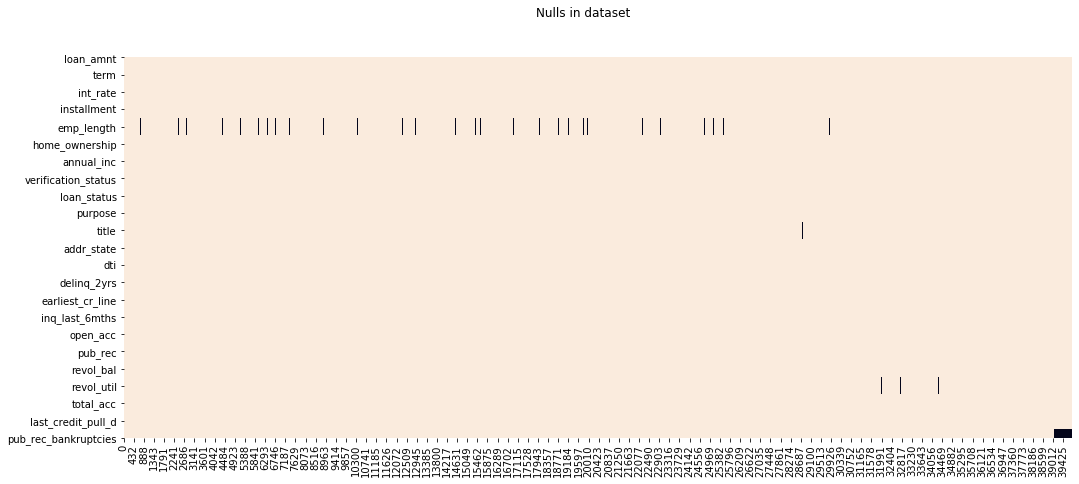

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize = (17,7))
sns.heatmap((loans_2007.isnull() == False).T, ax = ax, cbar=False)
plt.suptitle('Nulls in dataset')
plt.show()

In [26]:
null_counts = loans_2007.isnull().sum().sort_values(ascending = False)
null_counts[null_counts > 0]

emp_length              1036
pub_rec_bankruptcies     697
revol_util                50
title                     11
last_credit_pull_d         2
dtype: int64

Most of the columns have no missing values; however, 3 columns have 50 or less rows with missing values, and 2 columns, emp_length and pub_rec_bankruptcies, contain a relatively high amount of missing values.

It is obvious that employment length is frequently used in assessing how risky a potential borrower is - we'll keep this column.

Let's inspect the values of the column pub_rec_bankruptcies.

In [27]:
loans_2007['pub_rec_bankruptcies'].value_counts(normalize=True, dropna=False)

0.0    0.939438
1.0    0.042456
NaN    0.017978
2.0    0.000129
Name: pub_rec_bankruptcies, dtype: float64

We see there low variability. Let's keep this column and fill nas with 0 - most frequent value.

In [28]:
loans_2007['pub_rec_bankruptcies'] = loans_2007['pub_rec_bankruptcies'].fillna(0)

Let's remove the rest missing values.

In [29]:
loans_2007 = loans_2007.dropna(axis = 0)

In [30]:
loans_2007.dtypes.value_counts()

object     11
float64    11
int64       1
dtype: int64

Let's analyze object fields.

In [31]:
object_columns_df = loans_2007.select_dtypes(include=["object"])
object_columns_df.iloc[0]

term                     36 months
int_rate                    10.65%
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
revol_util                   83.7%
last_credit_pull_d        Jun-2016
Name: 0, dtype: object

In [32]:
object_columns_df.apply(n_unique)

term                       2
int_rate                 371
emp_length                11
home_ownership             5
verification_status        3
purpose                   14
title                  18881
addr_state                50
earliest_cr_line         514
revol_util              1086
last_credit_pull_d       107
dtype: int64

We'll convert int_rate, term and revol_util to numbers.

In [33]:
loans_2007['int_rate'] = loans_2007['int_rate'].str.extract('(\d+\.?\d*)').astype(float)/100
loans_2007['term'] = loans_2007['term'].str.extract('(\d+)').astype(int)
loans_2007['revol_util'] = loans_2007['revol_util'].str.extract('(\d+\.?\d*)').astype(float)/100

In [34]:
object_columns_df = loans_2007.select_dtypes(include=["object"])
object_columns_df.iloc[0]

emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
last_credit_pull_d        Jun-2016
Name: 0, dtype: object

Let's convert date fields to a float range variable.

In [35]:
loans_2007['earliest_cr_line'].astype('datetime64[ns]').min()

def dt_convert(s):
    s = s.astype('datetime64[ns]')
    return (s.max() - s) / (s.max() - s.min())

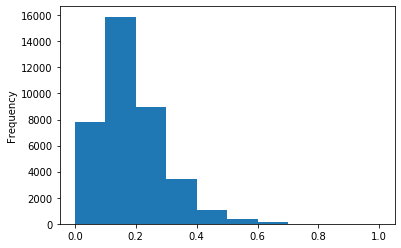

In [36]:
loans_2007['earliest_cr_line'] = dt_convert(loans_2007['earliest_cr_line'])
loans_2007['earliest_cr_line'].plot.hist()

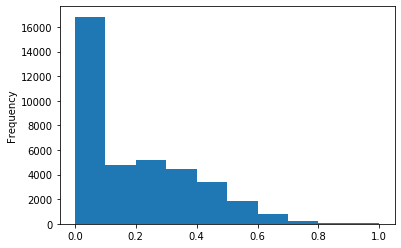

In [37]:
loans_2007['last_credit_pull_d'] = dt_convert(loans_2007['last_credit_pull_d'])
loans_2007['last_credit_pull_d'].plot.hist()

We converted the date columns to float representation with lower values identifying more recent dates. Let's analyze emp_length field.

In [38]:
loans_2007['emp_length'].value_counts()

10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64

Text(0.5, 1.0, 'Share of payed off loans')

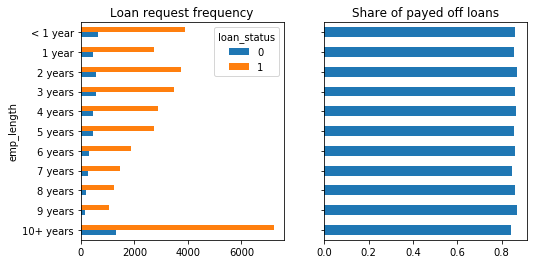

In [39]:
order = ["10+ years", "9 years", "8 years", "7 years",
 "6 years", "5 years", "4 years", "3 years",
 "2 years", "1 year", "< 1 year"]
yrs_ctab = pd.crosstab(loans_2007['emp_length'], loans_2007['loan_status']).reindex(order)
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (8,4))
yrs_ctab.plot.barh(ax = axs[0])
axs[0].set_title('Loan request frequency')
(yrs_ctab[1] / yrs_ctab.sum(axis = 1)).plot.barh(ax = axs[1])
axs[1].set_title('Share of payed off loans')

In the above distributions we see that there's high demand for loans coming from younger people. The share of payed off loans fluctuates a bit, but stays at relatively same level. Let's convert this field to numeric.

In [40]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans_2007 = loans_2007.replace(mapping_dict)

Text(0.5, 1.0, 'Share of payed off loans')

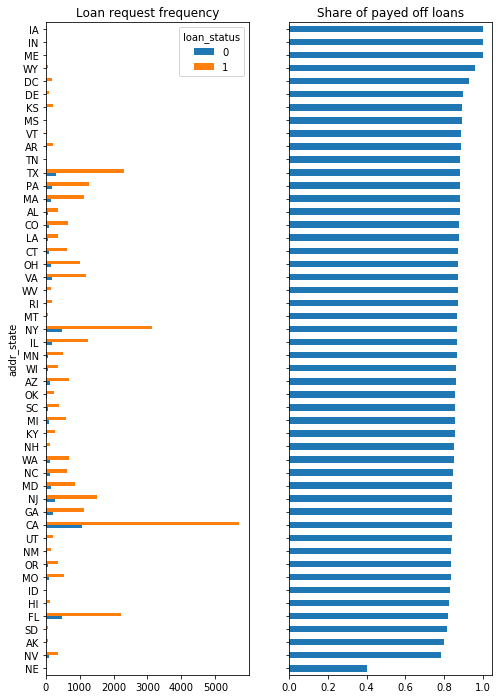

In [41]:
loans_2007["addr_state"].value_counts()

state_ctab = pd.crosstab(loans_2007['addr_state'], loans_2007['loan_status'])
state_ctab['share'] = state_ctab[1] / state_ctab.sum(axis = 1)
state_ctab = state_ctab.sort_values(by = 'share')
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (8,12))
state_ctab[[0,1]].plot.barh(ax = axs[0])
axs[0].set_title('Loan request frequency')
state_ctab['share'].plot.barh(ax = axs[1])
axs[1].set_title('Share of payed off loans')

There's too many values. However, we see that the share of the payed off loans changes from state to state. We can clusterize these states based on their loan performance. Let's keep this column and test how it affects performance of a classification model separately.

In [42]:
states = loans_2007["addr_state"]

In [43]:
loans_2007 = loans_2007.drop("addr_state", axis = 1)

We will also drop title column as it has too many distinct labels and repetitions. Purpose field has similar information and much fewer instances.

In [44]:
loans_2007 = loans_2007.drop('title', axis = 1)

## Predicting the pay off

The first model that we'll use will be logistic classifier. Before we start, however, we need to transform some of categorical variables to dummy because it will improve the model's performance.

In [45]:
dummy = ['term', 'emp_length', 'home_ownership', 'verification_status',
 'purpose', 'pub_rec_bankruptcies', 'pub_rec']
dset_dummy = pd.get_dummies(loans_2007, columns = dummy)

Let's separate features from target.

In [46]:
features = dset_dummy.drop('loan_status', axis = 1)
target = dset_dummy['loan_status']

As an error metric, we'll use True Positives Rate (TPR) and False Positives Rate (FPR). This is dictated by our desire to be more conservative, i.e. select less negative cases. However, this will also result in the decrease of correctly identified positive cases. Let's programm a function to calculate and prit these metrics.

In [47]:
def errors(t, p):
    # False positives.
    fp_filter = (p == 1) & (t == 0)
    fp = len(p[fp_filter])

    # True positives.`
    tp_filter = (p == 1) & (t == 1)
    tp = len(p[tp_filter])

    # False negatives.
    fn_filter = (p == 0) & (t == 1)
    fn = len(p[fn_filter])

    # True negatives
    tn_filter = (p == 0) & (t == 0)
    tn = len(p[tn_filter])

    # Rates
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return (tpr,fpr)

def print_errors(t, p):
    print('TPR: {:.4f}\nFPR: {:.4f}'.format(*errors(t,p)))

Let's start with simple logistic regression. We'll use 3-fold cross validation to ensure that we receive more correct error metrics for our models.

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

In [49]:
model = LogisticRegression(solver = 'liblinear')
predictions = cross_val_predict(model, features, target, cv=3)
print_errors(target, predictions)

TPR: 0.9994
FPR: 0.9989


The result tells us that the model predicted 1 for almost every line. THis happened due to the share of negatives in our dataset is much less than that of positives. Let's correct this with introduction of class weight. We'll use balanced for now.

In [50]:
model = LogisticRegression(class_weight="balanced",solver = 'liblinear')
predictions = cross_val_predict(model, features, target, cv=3)
print_errors(target, predictions)

TPR: 0.6313
FPR: 0.3782


We see that the numbers decrease. A good thing is that FPR is much less han TPR now. However, this cannot be thought s a conservative scenario. Let's see if imbalancing the penalty of the model a bit more will result in better numbers.

In [51]:
model = LogisticRegression(class_weight={0:10, 1:1},solver = 'liblinear')
predictions = cross_val_predict(model, features, target, cv=3)
print_errors(target, predictions)

TPR: 0.1283
FPR: 0.0694


The share of FPR decreased significantly, but niw we predict much less positives overall, and the ratio between TPR and FPR is still not optimal. What we can improve: select fewer and more meaningful features, add a feature representing the share of calculated installment to yearly income. We haven't include states field as well, and it has some potential for improving classification. We can also try to complicate the model a bit - probably a neural network with 2 hidden layers and ReLU activation (to set probability of all probably negative cases to 0) in the first layer will show different results. We can also ensamble this model with others. 

Let's check random forest model now.

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
model = RandomForestClassifier(random_state = 1)
predictions = cross_val_predict(model, features, target, cv=3)
print_errors(target, predictions)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TPR: 0.9540
FPR: 0.8593


We tested our dataset with dummy variables. But let's use the dataset without dummies next to see if the model will work better - it is not always required for a random forest to have dummies due to different algorythm.

In [54]:
features1 = loans_2007.drop('loan_status', axis = 1)
target1 = loans_2007['loan_status']

We'll need to convert str fields to numeric. Let's doo this.

In [55]:
features1['emp_length'] = features1['emp_length'].astype(int)
obj_columns = features1.select_dtypes(object).columns
obj_columns

Index(['home_ownership', 'verification_status', 'purpose'], dtype='object')

In [56]:
for i in obj_columns:
    features1[i] = features1[i].astype('category').cat.codes

In [57]:
model = RandomForestClassifier(random_state = 1)
predictions = cross_val_predict(model, features1, target1, cv=3)
print_errors(target, predictions)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TPR: 0.9455
FPR: 0.8430


We see the result is different than that of logistic regression: It predicts less false positives. Let's add some class weights.

In [58]:
model = RandomForestClassifier(random_state = 1, class_weight = 'balanced')
predictions = cross_val_predict(model, features1, target1, cv=3)
print_errors(target, predictions)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TPR: 0.9613
FPR: 0.8788


The TPR slightly increased, however, FPR rose as well, and with a higher margin. Let's increase the imbalance.

In [59]:
model = RandomForestClassifier(random_state = 1, class_weight = {0:10, 1:1})
predictions = cross_val_predict(model, features1, target1, cv=3)
print_errors(target, predictions)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TPR: 0.9633
FPR: 0.8914


We actually see that the model did not become being better. Let's switch the weights out of curiosity.

In [60]:
model = RandomForestClassifier(random_state = 1, class_weight = {0:1, 1:10})
predictions = cross_val_predict(model, features1, target1, cv=3)
print_errors(target, predictions)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TPR: 0.9218
FPR: 0.7755


Well, that's an interesting result. While penalising the incorrect classification of positive classes more, the TPR decreased. And FPR decreased even more.

**Let's stop here for now.**

Some thoughts for future exploration:
We need to add the state field to the features but the states should be clustered by their risk first. Next, we need to add a share of installment to income. And overall, we have not spent time on analysis of selected features - that seems to be required in order to get better results.

Also, it is interesting to see if a neural network with several layers and a gombination of logistic and relu activation would show potential.

We'll come to this exercise later.